<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/10-Pix2Pix/completeAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Görsel işlemeler için Eksik Tamamlama Yapay Zekası

Bu çalışmada amaç elimizdeki bir kısmı eksik fotoğrafları tamamlayan  bir model eğitmek.

In [1]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data import Dataset
import tensorflow as tf
import math
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.display import clear_output



Burada aslında 500 adet görsel olan basit bir dataset indiriyoruz. Manuel olarak onları siyah beyaz yapıp renkli halleri ile eşleştirerek model eğitiminde kullancağız.

In [2]:
!wget -q "https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/10-Pix2Pix/archive.zip"


In [3]:
!unzip -q archive.zip

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
BATCH_SIZE=16
# Define paths
image_folder = "archive"  # Update with actual path
TARGET_SIZE = (128, 128)
BORDER_SIZE=15
start_y = BORDER_SIZE
start_x = BORDER_SIZE
end_y = TARGET_SIZE[1]- BORDER_SIZE
end_x = TARGET_SIZE[0] - BORDER_SIZE


# Load images and create dataset
border_images, color_images = [], []

for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)

    # Load and resize color (high-res) image
    color_img = img_to_array(load_img(img_path, target_size=TARGET_SIZE))

    # Crop images by adding black borders

    # Place the original image in the center of the black-bordered image
    black_border_img = np.zeros_like(color_img)
    black_border_img[start_y:end_y, start_x:end_x] = color_img[start_y:end_y, start_x:end_x]

    # Normalize images
    border_images.append(black_border_img / 255.0)
    color_images.append(color_img / 255.0)


# Convert to NumPy arrays
border_images = np.array(border_images, dtype=np.float32)
color_images = np.array(color_images, dtype=np.float32)

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((border_images, color_images))
dataset = dataset.batch(BATCH_SIZE).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)
print(dataset.element_spec)

# Count total images
total_elements = sum(1 for _ in dataset)
total_images = total_elements * BATCH_SIZE  # batch size is 32
print(f"Total images in dataset: {total_images}")



(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))
Total images in dataset: 1008


In [5]:
print(dataset.element_spec)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))


Black White Shape: (1000, 128, 128, 3)
Color Shape: (1000, 128, 128, 3)


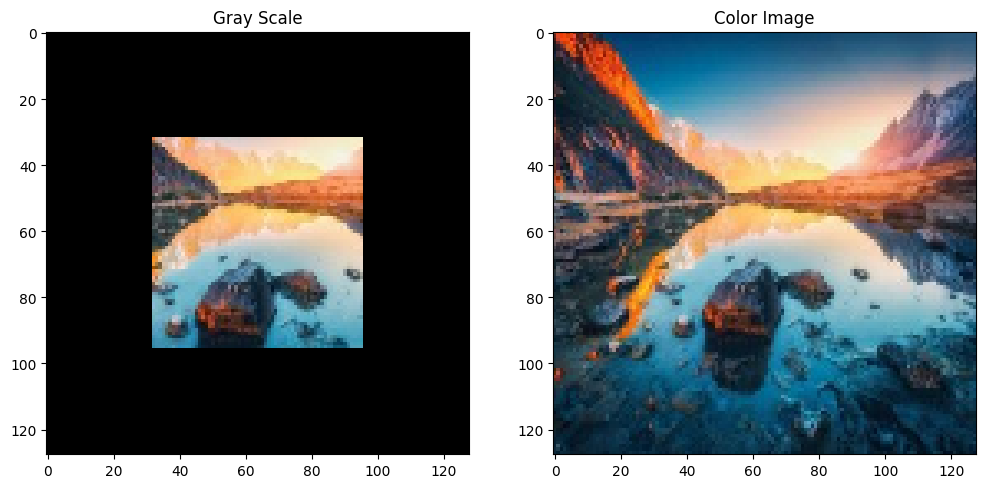

In [6]:

print("Black White Shape:", border_images.shape)
print("Color Shape:", color_images.shape)

# Plot the first image in the batch
plt.figure(figsize=(12, 6))

# Low resolution image
plt.subplot(1, 2, 1)
plt.imshow(border_images[0])  # Display first image in batch
plt.title("Gray Scale")

# High resolution image
plt.subplot(1, 2, 2)
plt.imshow(color_images[0])  # Display first image in batch
plt.title("Color Image")

plt.show()


In [7]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, Input, Conv2DTranspose
from tensorflow.keras.models import Model

def build_completer():
    # Input layer (Grayscale 128x128x1)
    inputs = Input(shape=(128, 128, 3))  # Tek kanallı giriş

    # İlk konvolüsyon bloğu (özellik çıkarımı)
    x = Conv2D(64, (9, 9), padding="same")(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)  # Use `negative_slope` instead of `alpha`
    x = BatchNormalization()(x)

    # Özellik çıkarımı katmanı
    x = Conv2D(128, (5, 5), padding="same")(x)
    x = LeakyReLU(negative_slope=0.2)(x)  # Use `negative_slope` instead of `alpha`
    x = BatchNormalization()(x)

    # Transposed Convolution (128x128 → 128x128, sadece kanal genişletme / özellik çıkarımını arttırma)
    x = Conv2DTranspose(128, (4, 4), strides=(1, 1), padding="same")(x)
    x = LeakyReLU(negative_slope=0.2)(x)  # Use `negative_slope` instead of `alpha`
    x = BatchNormalization()(x)

    # Residual bağlantı ile detay koruma
    residual = Conv2D(128, (5, 5), padding="same")(x)  # Change filters to 128 to match the main branch
    residual = LeakyReLU(negative_slope=0.2)(residual)  # Use `negative_slope` instead of `alpha`
    residual = BatchNormalization()(residual)
    x = Add()([x, residual])

    # Çıkış katmanı (128x128 RGB)
    outputs = Conv2D(3, (5, 5), padding="same", activation="sigmoid")(x)

    # Model oluşturma
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    return model

# Modeli oluştur ve özetle
model = build_completer()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │         15,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │        204,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 128)  │        262,272 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │        409,728 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 3)    │          9,603 │ add[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 903,939 (3.45 MB)

 Trainable params: 903,043 (3.44 MB)

 Non-trainable params: 896 (3.50 KB)

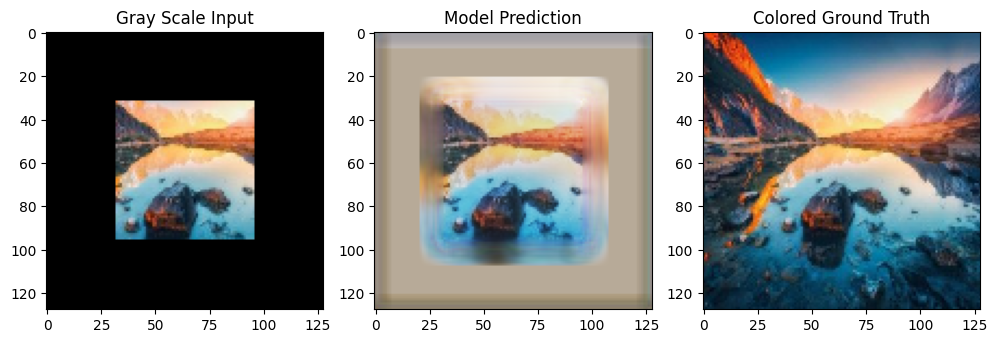

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.0487 - mae: 0.1643


In [8]:

class DisplayPrediction(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data
        self.patience = 10
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0

    def on_epoch_end(self, epoch, logs=None):

        # early stop
        current_loss = logs.get('loss')

        # Check if the loss has improved
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        # If loss hasn't improved for 'patience' epochs, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            self.model.stop_training = True

        # Get a sample of the validation data
        gray_images, color_images = next(iter(self.val_data))

        # Ensure low_gray_imagesres and high_res have a batch dimension
        gray_images = tf.expand_dims(gray_images, axis=0) if len(gray_images.shape) == 3 else gray_images
        color_images = tf.expand_dims(color_images, axis=0) if len(color_images.shape) == 3 else color_images

        # Generate prediction from the model
        pred = self.model.predict(gray_images)

        # Display images
        plt.figure(figsize=(10, 5))

        # gray_images input
        plt.subplot(1, 3, 1)
        plt.imshow(gray_images[0],cmap="gray")  # Show first image of batch
        plt.title("Gray Scale Input")

        # Model prediction
        plt.subplot(1, 3, 2)
        plt.imshow(pred[0])  # Show first predicted image
        plt.title("Model Prediction")

        # color_images ground truth
        plt.subplot(1, 3, 3)
        plt.imshow(color_images[0])  # Show first high-res image
        plt.title("Colored Ground Truth")

        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

# Convert to tf.data.Dataset properly if it's not in batch form yet
val_data = tf.data.Dataset.from_tensor_slices((border_images[:10], color_images[:10]))  # Use 10 samples for validation
val_data = val_data.batch(1)  # Ensure the data is batched

# Add the callback to training
callback = DisplayPrediction(val_data)
#tf.dataset olduğundan batch size yukarda
# Train the model with the callback added history
history = model.fit(dataset, epochs=150, callbacks=[callback])


In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()


In [ ]:
!wget -q  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test1.jpg -O test1.jpg
!wget -q https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test2.jpg -O test2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


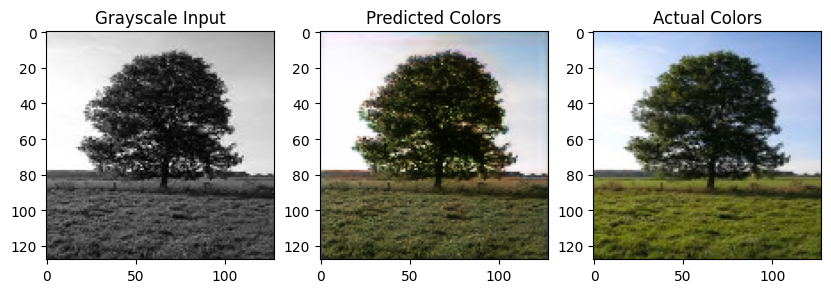

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def color_new_image(model, image_path, target_size=(128, 128)):
    # Load the new image and resize it to 64x64
    img = img_to_array(load_img(image_path, target_size=target_size))

    # create grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Reshape gray_image to have the correct dimensions
    gray_image = gray_image.reshape(1, target_size[0], target_size[1], 1) #add batch and channel dimension

    # Normalize the images
    gray_image = gray_image / 255.0
    img = img / 255.0

    # Make prediction using the model
    pred = model.predict(gray_image)

    # Return both the resized low-res image and the prediction
    return gray_image[0], pred[0]  # Return gray_image instead of low_res

# Example usage
image_path = "test1.jpg"
low_res, predicted = color_new_image(model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 3, 1)
plt.imshow(low_res[:,:,0], cmap="gray") #adjusted to display image correctly
plt.title("Grayscale Input")

# Display the predicted high-resolution image
plt.subplot(1, 3, 2)
plt.imshow(predicted)
plt.title("Predicted Colors")

plt.subplot(1, 3, 3)
img=cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(128,128))
plt.imshow(img) #adjusted to display image correctly
plt.title("Actual Colors")



plt.show()

Sace and use later

In [ ]:
# Save the model in H5 format
model.save("color_model.keras")


In [ ]:
loaded_model = tf.keras.models.load_model("color_model.keras")

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def upscale_new_image(model, image_path):
    # Load the new image and resize it to 128,128
    img = img_to_array(load_img(image_path, target_size=(128,128)))

    # Create low-res version by downscaling (to simulate the low-res input for the model)
    low_res = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize the images
    low_res = low_res / 255.0
    img = img / 255.0

    # Expand dimensions for batch processing
    low_res = np.expand_dims(low_res, axis=0)

    # Make prediction using the model
    pred = model.predict(low_res)

    # Return both the resized low-res image and the prediction
    return low_res[0], pred[0]

# Example usage
image_path = "test1.jpg"

# Load model (if already saved and needs to be loaded)
# model = tf.keras.models.load_model("upscaler_model.h5")

# Predict with the model
low_res, predicted = upscale_new_image(model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 2, 1)
plt.imshow(low_res)
plt.title("Low-Res (64x64) Input")

# Display the predicted high-resolution image
plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title("Predicted High-Res")

plt.show()

# Save model for later use
model.save("upscaler_model.h5")  # Save the model

ValueError: as_list() is not defined on an unknown TensorShape.